<a href="https://colab.research.google.com/github/bdip635/Histopathology-Classification/blob/main/DENSENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2

In [2]:
!pip install pkbar
import pkbar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = 'cuda'

batch_size= 32
num_classes= 4
input_shape=(3,224,224)

In [5]:
main = 'drive/My Drive/Course Project Image Processing - Histopathology/KMC Dataset'
work = 'drive/My Drive/Course Project Image Processing - Histopathology/db_dir'

train_dir = os.path.join(main,'Training')
test_dir = os.path.join(main,'Test')
val_dir = os.path.join(main,'Validation')

In [6]:
train_data= datasets.ImageFolder(train_dir, transform= transforms.ToTensor())
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [7]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [8]:
class_dict=train_data.class_to_idx
print(class_dict)
class_labels = class_dict.values()
print(class_labels)

{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3}
dict_values([0, 1, 2, 3])


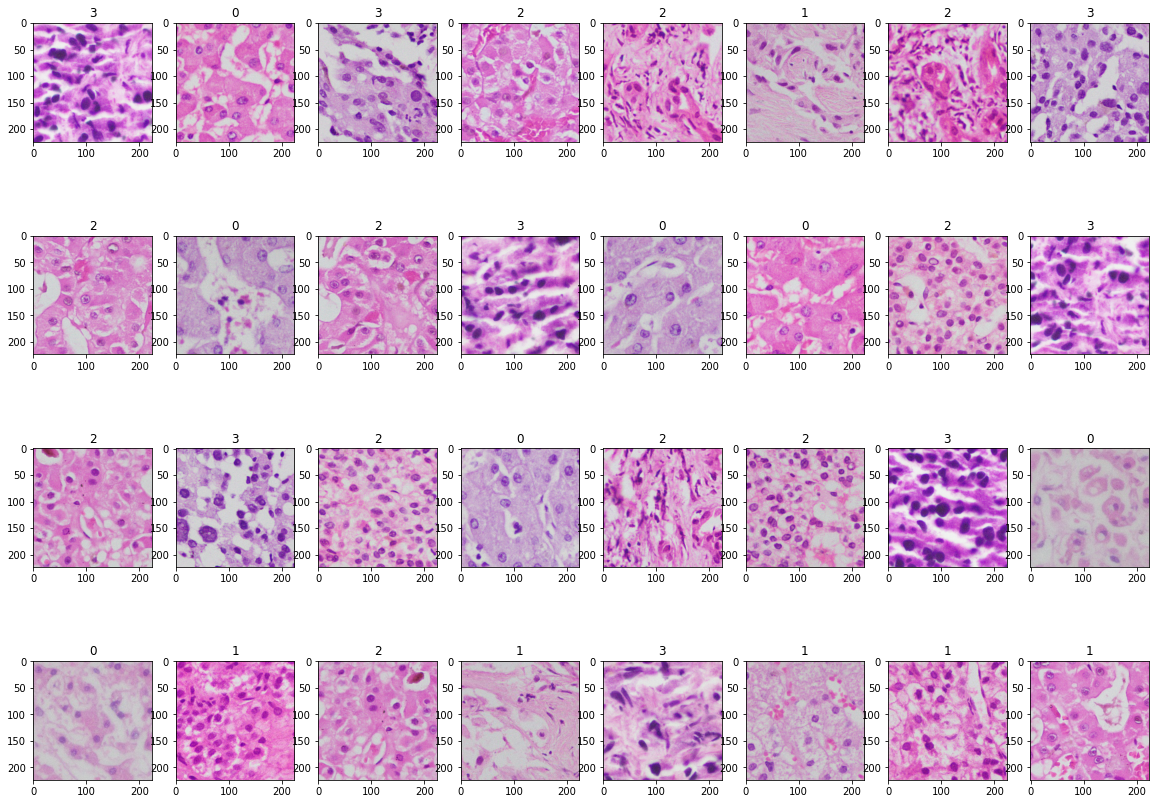

In [15]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,15))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

In [10]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

In [11]:
class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
        self.avg_pool=nn.AvgPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return self.avg_pool(out)

In [12]:
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [13]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=4, growth_rate=32,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet, self).__init__()
        in_planes = 64
        if bottleneck == True:
            block = BottleneckBlock
        else:
            block = BasicBlock
        # 1st conv before any dense block
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,
                                padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # 1st block
        self.block1 = DenseBlock(6, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+6*growth_rate)
        self.trans1 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        
        # 2nd block
        self.block2 = DenseBlock(12, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+12*growth_rate)
        self.trans2 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = in_planes//2
        
        # 3rd block
        self.block3 = DenseBlock(24, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+24*growth_rate)
        self.trans3 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = in_planes//2
       
        #4th block
        self.block4 = DenseBlock(16, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+16*growth_rate)
        
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool=nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(in_planes, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.in_planes = in_planes
    def forward(self, x):
        out = self.layer1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.trans3(self.block3(out))
        out = self.block4(out)
        out = self.relu(self.bn1(out))
        out = self.avg_pool(out)
        out = out.view(-1, self.in_planes)
        out=  self.fc1(out)
        return self.fc2(out)

In [14]:
model = DenseNet().to(device)
summary(model,input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
  BottleneckBlock-11           [-1, 96, 56, 56]               0
      BatchNorm2d-12           [-1, 96, 56, 56]             192
             ReLU-13           [-1, 96, 56, 56]               0
           Conv2d-14          [-1, 128,

In [27]:
learning_rate = 1e-5
num_epochs = 50

In [17]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name, map_location=torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [28]:
check_pt_file = 'drive/My Drive/Course Project Image Processing - Histopathology/db_dir/densenet1.pth.tar'

In [29]:
model, optimizer = load_checkpoint(model, optimizer, check_pt_file)

In [21]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [30]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf

for epoch in range(num_epochs):
  train_losses=[]
### TRAINING
  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:
    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP
    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)
    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION
  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)
  for batch_idx, (data, targets) in val_loop:
    val_losses=[]
    model.eval()
   
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= val_loss.item()
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/50
83/83 [==============================] - 41s 497ms/step - loss: 0.0829 - accuracy: 0.9690
Epoch: 1/50
8/9 [=========================>....] - ETA: 0s - val_loss: 0.5917 - val_accuracy: 0.8490
Improved validation loss: 0.3387
Saving the model to drive/My Drive/Course Project Image Processing - Histopathology/db_dir/densenet1.pth.tar

9/9 [==============================] - 3s 286ms/step - val_loss: 0.5917 - val_accuracy: 0.8490
Epoch: 2/50
83/83 [==============================] - 41s 491ms/step - loss: 0.0861 - accuracy: 0.9672
Epoch: 2/50
9/9 [==============================] - 2s 234ms/step - val_loss: 1.0215 - val_accuracy: 0.7852
Epoch: 3/50
83/83 [==============================] - 41s 494ms/step - loss: 0.0600 - accuracy: 0.9768
Epoch: 3/50
9/9 [==============================] - 2s 235ms/step - val_loss: 0.9805 - val_accuracy: 0.7591
Epoch: 4/50
83/83 [==============================] - 41s 493ms/step - loss: 0.0683 - accuracy: 0.9680
Epoch: 4/50
9/9 [======================

KeyboardInterrupt: ignored

#Testing

In [31]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model_a, class_labels):

    model_a.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model_a(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [32]:
check_pt_file

'drive/My Drive/Course Project Image Processing - Histopathology/db_dir/densenet1.pth.tar'

In [35]:
densenet, _= load_checkpoint(model, optimizer, check_pt_file)
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(val_loader, densenet, class_labels)

In [36]:
print('CONFUSION MATRIX:\n',confusion_matrix,'\n')

print("PRECISION:",precision)
print("RECALL:",recall)
print("F1 SCORE:",f1)
print("ACCURACY:",accuracy)

print("PRECISION:",np.mean(precision))
print("RECALL:",np.mean(recall))
print("F1 SCORE:",np.mean(f1))
print("ACCURACY:",np.mean(accuracy))

CONFUSION MATRIX:
 [[70  0  0  0]
 [ 0 72  7  1]
 [ 0 10 70  0]
 [ 0  0  0 50]] 

PRECISION: [[1.   ]
 [0.9  ]
 [0.875]
 [1.   ]]
RECALL: [[1.        ]
 [0.87804878]
 [0.90909091]
 [0.98039216]]
F1 SCORE: [[1.        ]
 [0.88888889]
 [0.89171975]
 [0.99009901]]
ACCURACY: [[1.        ]
 [0.93571429]
 [0.93928571]
 [0.99642857]]
PRECISION: 0.94375
RECALL: 0.9418829616103648
F1 SCORE: 0.9426769110032022
ACCURACY: 0.9678571428571429
